In [1]:
# import os
# print(os.getcwd())

# try:
#     os.chdir("ResEmoteNet-main")  # Change to the script's directory
# except:
#     print("Already in the correct directory")

# # Now run the script
# run_command = "train_files/ResEmoteNet_train.py"
# %run {run_command}

In [2]:
# !pip3 install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cu128
# !pip install pandas
# !pip install tqdm
# !pip install matplotlib
# !pip install opencv-python
# !pip install scikit-learn
# !pip install seaborn

In [3]:
# Required Libraries
import os
import random
import shutil
import torch
from collections import defaultdict
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

In [4]:
# Dataset class for the custom dataset
class Four4All(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# ResEmoteNet Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)
    
    
class ResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_ch != out_ch:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_ch)
            )
            
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
    
class ResEmoteNet(nn.Module):
    def __init__(self):
        super(ResEmoteNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu = nn.ReLU(inplace=True)
        self.se = SEBlock(256)
        
        self.res_block1 = ResidualBlock(256, 512, stride=2)
        self.res_block2 = ResidualBlock(512, 1024, stride=2)
        self.res_block3 = ResidualBlock(1024, 2048, stride=2)
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(256, 7)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        x = self.se(x)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout2(x)
        x = self.fc4(x)
        return x

# ResEmoteNet Training

In [6]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

def TrainResEmoteNet(data_directory, dataset_name, device, lr, batch_size, momentum, weight_decay, patience, num_epochs, checkpoint=None):
    # Transform the dataset
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    # Load the dataset
    train_dataset = Four4All(csv_file=data_directory+'/train/labels.csv',
                            img_dir=data_directory+'/train', transform=transform)

    val_dataset = Four4All(csv_file=data_directory+'/validation/labels.csv', 
                        img_dir=data_directory+'/validation/', transform=transform)

    # test_dataset = Four4All(csv_file=data_directory+'/test/labels.csv', 
    #                         img_dir=data_directory+'/test', transform=transform)

    num_classes = train_dataset.labels.iloc[:, 1].nunique()
    print(f"Number of classes: {num_classes}")

    # Calculate class weights for the training dataset (balanced weights) - Modification
    labels = train_dataset.labels.iloc[:, 1].values
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    # Placeholder for storing results
    # results = []
    
    # Load the dataset with the current batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    # Reinitialise the model
    model = ResEmoteNet().to(device)
    model.fc4 = nn.Linear(256, num_classes).to(device)

    if checkpoint is not None:
        model.load_state_dict(torch.load(checkpoint))
    
    # Hyperparameters
    # criterion = torch.nn.CrossEntropyLoss()
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights)  # Apply class weights here - Modification
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

    # Training parameters
    patience_counter = 0
    # epoch_counter = 0
    best_val_acc = 0

    # train_losses = []
    # val_losses = []
    # train_accuracies = []
    # val_accuracies = []
    # test_losses = []
    # test_accuracies = []

    # Start training
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        # train_losses.append(train_loss)
        # train_accuracies.append(train_acc)

        # Validation evaluation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_acc = val_correct / val_total
        # val_losses.append(val_loss)
        # val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")
        # epoch_counter += 1

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            # torch.save(model.state_dict(), f'{data_directory}/ResEmoteNet_best_model_LR_{lr}_BS_{batch_size}_M_{momentum}_WD_{weight_decay}.pth')
            os.makedirs("Models", exist_ok=True)
            print(f"Saving model with best validation accuracy: {best_val_acc}")
            torch.save(model.state_dict(), f'Models/ResEmoteNet_{dataset_name}_best_model_LR_{lr}_BS_{batch_size}_M_{momentum}_WD_{weight_decay}_P_{patience}_E_{num_epochs}.pth')
        else:
            patience_counter += 1
            print(f"No improvement in validation accuracy for {patience_counter} epochs.")
        
        if patience_counter > patience:
            print("Stopping early due to lack of improvement in validation accuracy.")
            break

    # # Store the results for this hyperparameter combination
    # results.append({
    #     'lr': lr,
    #     'batch_size': batch_size,
    #     'momentum': momentum,
    #     'weight_decay': weight_decay,
    #     'best_val_acc': best_val_acc,
    #     'train_losses': train_losses,
    #     'val_losses': val_losses,
    #     'train_accuracies': train_accuracies,
    #     'val_accuracies': val_accuracies
    # })

    print(f"Finished training with lr={lr}, batch_size={batch_size}, momentum={momentum}, weight_decay={weight_decay}")
    print(f"Best validation accuracy: {best_val_acc}\n")

    # # Convert results to DataFrame
    # results_df = pd.DataFrame(results)

    # # Save results to CSV for later analysis
    # results_df.to_csv(f'{data_directory}/hyperparameter_search_results.csv', index=False)

In [7]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

dataset_name, data_directory = 'AffectNet', '../../Datasets/AffectNet_Structured_Aligned' #51% Acc on Test Set 0.001 16 0.9 1e-4 15 300
# dataset_name, data_directory = 'CK+', '../../Datasets/CK+_Structured'
# dataset_name, data_directory = 'FER', '../../Datasets/FER_Structured' #??% Acc on Test Set 0.001 16 0.9 1e-4 15 300
# dataset_name, data_directory = 'JAFFE', '../../Datasets/JAFFE_Structured'
# dataset_name, data_directory = 'RAF-DB', '../../Datasets/RAF-DB_Structured' #79% Acc on Test Set 0.001 16 0.9 1e-4 15 300

lr = 0.001
batch_size = 16
momentum = 0.9
weight_decay = 1e-4
patience = 15
num_epochs = 300 #5 #80
checkpoint = None#'Models/ResEmoteNet_AffectNet_best_model_LR_0.001_BS_16_M_0.9_WD_0.0001_P_15_E_300.pth'

TrainResEmoteNet(data_directory, dataset_name, device, lr, batch_size, momentum, weight_decay, patience, num_epochs, checkpoint)

Using cuda device
Number of classes: 8


Epoch 1/300: 100%|██████████| 2347/2347 [09:04<00:00,  4.31it/s]


Epoch 1, Train Loss: 1.9905538593498655, Train Accuracy: 0.20448977417980402, Validation Loss: 1.7984246110916138, Validation Accuracy: 0.28875
Saving model with best validation accuracy: 0.28875


Epoch 2/300: 100%|██████████| 2347/2347 [03:06<00:00, 12.61it/s]


Epoch 2, Train Loss: 1.773474157186686, Train Accuracy: 0.3154825308904985, Validation Loss: 1.5957443475723267, Validation Accuracy: 0.3925
Saving model with best validation accuracy: 0.3925


Epoch 3/300: 100%|██████████| 2347/2347 [03:03<00:00, 12.78it/s]


Epoch 3, Train Loss: 1.6629390684553649, Train Accuracy: 0.363069876438006, Validation Loss: 1.5338991737365724, Validation Accuracy: 0.42
Saving model with best validation accuracy: 0.42


Epoch 4/300: 100%|██████████| 2347/2347 [02:57<00:00, 13.23it/s]


Epoch 4, Train Loss: 1.5948751361562081, Train Accuracy: 0.3963304218150831, Validation Loss: 1.489742977619171, Validation Accuracy: 0.44125
Saving model with best validation accuracy: 0.44125


Epoch 5/300: 100%|██████████| 2347/2347 [02:56<00:00, 13.33it/s]


Epoch 5, Train Loss: 1.5319140186754754, Train Accuracy: 0.4271942905837239, Validation Loss: 1.449976485967636, Validation Accuracy: 0.46375
Saving model with best validation accuracy: 0.46375


Epoch 6/300: 100%|██████████| 2347/2347 [02:56<00:00, 13.26it/s]


Epoch 6, Train Loss: 1.4826017245110625, Train Accuracy: 0.44857797187899445, Validation Loss: 1.400649789571762, Validation Accuracy: 0.4725
Saving model with best validation accuracy: 0.4725


Epoch 7/300: 100%|██████████| 2347/2347 [02:56<00:00, 13.29it/s]


Epoch 7, Train Loss: 1.4335892049363181, Train Accuracy: 0.4706007669365147, Validation Loss: 1.3982626497745514, Validation Accuracy: 0.50125
Saving model with best validation accuracy: 0.50125


Epoch 8/300: 100%|██████████| 2347/2347 [02:56<00:00, 13.32it/s]


Epoch 8, Train Loss: 1.3945840336334772, Train Accuracy: 0.4853003834682573, Validation Loss: 1.365288803577423, Validation Accuracy: 0.50375
Saving model with best validation accuracy: 0.50375


Epoch 9/300: 100%|██████████| 2347/2347 [02:56<00:00, 13.33it/s]


Epoch 9, Train Loss: 1.36015322706676, Train Accuracy: 0.49952066467831274, Validation Loss: 1.3422509944438934, Validation Accuracy: 0.50875
Saving model with best validation accuracy: 0.50875


Epoch 10/300: 100%|██████████| 2347/2347 [02:56<00:00, 13.29it/s]


Epoch 10, Train Loss: 1.3170493585940468, Train Accuracy: 0.5161908819769919, Validation Loss: 1.3756532227993012, Validation Accuracy: 0.5025
No improvement in validation accuracy for 1 epochs.


Epoch 11/300: 100%|██████████| 2347/2347 [03:00<00:00, 12.97it/s]


Epoch 11, Train Loss: 1.2800044502458219, Train Accuracy: 0.5333138048572645, Validation Loss: 1.3771359992027283, Validation Accuracy: 0.49
No improvement in validation accuracy for 2 epochs.


Epoch 12/300: 100%|██████████| 2347/2347 [03:08<00:00, 12.43it/s]


Epoch 12, Train Loss: 1.250936674904102, Train Accuracy: 0.5437260332339157, Validation Loss: 1.3555296814441682, Validation Accuracy: 0.48375
No improvement in validation accuracy for 3 epochs.


Epoch 13/300: 100%|██████████| 2347/2347 [03:06<00:00, 12.59it/s]


Epoch 13, Train Loss: 1.2089695969844911, Train Accuracy: 0.5597571367703451, Validation Loss: 1.3921126806735993, Validation Accuracy: 0.49875
No improvement in validation accuracy for 4 epochs.


Epoch 14/300: 100%|██████████| 2347/2347 [03:05<00:00, 12.65it/s]


Epoch 14, Train Loss: 1.178855340405632, Train Accuracy: 0.5713144439710268, Validation Loss: 1.4113532483577729, Validation Accuracy: 0.49375
No improvement in validation accuracy for 5 epochs.


Epoch 15/300: 100%|██████████| 2347/2347 [03:06<00:00, 12.57it/s]


Epoch 15, Train Loss: 1.1436339275451939, Train Accuracy: 0.5847890924584576, Validation Loss: 1.343358074426651, Validation Accuracy: 0.50625
No improvement in validation accuracy for 6 epochs.


Epoch 16/300: 100%|██████████| 2347/2347 [03:07<00:00, 12.55it/s]


Epoch 16, Train Loss: 1.1074637126861657, Train Accuracy: 0.5996751171708564, Validation Loss: 1.348540916442871, Validation Accuracy: 0.5125
Saving model with best validation accuracy: 0.5125


Epoch 17/300: 100%|██████████| 2347/2347 [03:07<00:00, 12.55it/s]


Epoch 17, Train Loss: 1.0718255378004333, Train Accuracy: 0.6081700042607584, Validation Loss: 1.3862537014484406, Validation Accuracy: 0.49875
No improvement in validation accuracy for 1 epochs.


Epoch 18/300: 100%|██████████| 2347/2347 [03:06<00:00, 12.60it/s]


Epoch 18, Train Loss: 1.0402252392206082, Train Accuracy: 0.6269439710268427, Validation Loss: 1.4178816390037536, Validation Accuracy: 0.49875
No improvement in validation accuracy for 2 epochs.


Epoch 19/300: 100%|██████████| 2347/2347 [03:02<00:00, 12.89it/s]


Epoch 19, Train Loss: 0.9971879663673624, Train Accuracy: 0.6406582871751172, Validation Loss: 1.443170747756958, Validation Accuracy: 0.49125
No improvement in validation accuracy for 3 epochs.


Epoch 20/300: 100%|██████████| 2347/2347 [03:02<00:00, 12.88it/s]


Epoch 20, Train Loss: 0.9614775890891584, Train Accuracy: 0.6547720494247976, Validation Loss: 1.4263289642333985, Validation Accuracy: 0.52125
Saving model with best validation accuracy: 0.52125


Epoch 21/300: 100%|██████████| 2347/2347 [03:03<00:00, 12.81it/s]


Epoch 21, Train Loss: 0.9288447517687379, Train Accuracy: 0.6683265871325096, Validation Loss: 1.4144054329395295, Validation Accuracy: 0.5025
No improvement in validation accuracy for 1 epochs.


Epoch 22/300: 100%|██████████| 2347/2347 [03:02<00:00, 12.83it/s]


Epoch 22, Train Loss: 0.8906382789726607, Train Accuracy: 0.6835854282062207, Validation Loss: 1.5485163259506225, Validation Accuracy: 0.49375
No improvement in validation accuracy for 2 epochs.


Epoch 23/300: 100%|██████████| 2347/2347 [03:06<00:00, 12.59it/s]


Epoch 23, Train Loss: 0.85563369000725, Train Accuracy: 0.6948498082658713, Validation Loss: 1.5389449083805085, Validation Accuracy: 0.5175
No improvement in validation accuracy for 3 epochs.


Epoch 24/300: 100%|██████████| 2347/2347 [02:59<00:00, 13.09it/s]


Epoch 24, Train Loss: 0.8247067137860622, Train Accuracy: 0.7068065615679591, Validation Loss: 1.5824081909656524, Validation Accuracy: 0.5
No improvement in validation accuracy for 4 epochs.


Epoch 25/300: 100%|██████████| 2347/2347 [03:04<00:00, 12.69it/s]


Epoch 25, Train Loss: 0.7756791340070529, Train Accuracy: 0.726033233915637, Validation Loss: 1.6840034651756286, Validation Accuracy: 0.49125
No improvement in validation accuracy for 5 epochs.


Epoch 26/300: 100%|██████████| 2347/2347 [03:00<00:00, 13.00it/s]


Epoch 26, Train Loss: 0.7567733927043794, Train Accuracy: 0.7342618236046016, Validation Loss: 1.549067485332489, Validation Accuracy: 0.5
No improvement in validation accuracy for 6 epochs.


Epoch 27/300: 100%|██████████| 2347/2347 [03:02<00:00, 12.86it/s]


Epoch 27, Train Loss: 0.7216283031852386, Train Accuracy: 0.7444077545803153, Validation Loss: 1.6775024223327637, Validation Accuracy: 0.50125
No improvement in validation accuracy for 7 epochs.


Epoch 28/300: 100%|██████████| 2347/2347 [03:00<00:00, 13.02it/s]


Epoch 28, Train Loss: 0.6830481125488655, Train Accuracy: 0.758494887089902, Validation Loss: 1.6712574899196624, Validation Accuracy: 0.48875
No improvement in validation accuracy for 8 epochs.


Epoch 29/300: 100%|██████████| 2347/2347 [03:09<00:00, 12.37it/s]


Epoch 29, Train Loss: 0.6569202967372203, Train Accuracy: 0.7709576054537708, Validation Loss: 1.7403355914354324, Validation Accuracy: 0.48375
No improvement in validation accuracy for 9 epochs.


Epoch 30/300: 100%|██████████| 2347/2347 [03:07<00:00, 12.52it/s]


Epoch 30, Train Loss: 0.6214046142915994, Train Accuracy: 0.7826746910950149, Validation Loss: 1.7646915137767791, Validation Accuracy: 0.49125
No improvement in validation accuracy for 10 epochs.


Epoch 31/300: 100%|██████████| 2347/2347 [03:08<00:00, 12.44it/s]


Epoch 31, Train Loss: 0.5891617525751458, Train Accuracy: 0.7948444823178525, Validation Loss: 1.833500199317932, Validation Accuracy: 0.50125
No improvement in validation accuracy for 11 epochs.


Epoch 32/300: 100%|██████████| 2347/2347 [03:06<00:00, 12.60it/s]


Epoch 32, Train Loss: 0.5668149146758905, Train Accuracy: 0.8044045590115041, Validation Loss: 1.8323174238204956, Validation Accuracy: 0.4925
No improvement in validation accuracy for 12 epochs.


Epoch 33/300: 100%|██████████| 2347/2347 [03:08<00:00, 12.44it/s]


Epoch 33, Train Loss: 0.5328080368628642, Train Accuracy: 0.8148434171282488, Validation Loss: 1.8970809161663056, Validation Accuracy: 0.49875
No improvement in validation accuracy for 13 epochs.


Epoch 34/300: 100%|██████████| 2347/2347 [03:10<00:00, 12.32it/s]


Epoch 34, Train Loss: 0.5119579063595916, Train Accuracy: 0.8219002982530891, Validation Loss: 1.8470932841300964, Validation Accuracy: 0.495
No improvement in validation accuracy for 14 epochs.


Epoch 35/300: 100%|██████████| 2347/2347 [03:07<00:00, 12.51it/s]


Epoch 35, Train Loss: 0.4834163423800626, Train Accuracy: 0.8327652322113336, Validation Loss: 1.9496914446353912, Validation Accuracy: 0.4975
No improvement in validation accuracy for 15 epochs.


Epoch 36/300: 100%|██████████| 2347/2347 [03:08<00:00, 12.48it/s]


Epoch 36, Train Loss: 0.4626434112882736, Train Accuracy: 0.8398753728163613, Validation Loss: 1.9146533942222594, Validation Accuracy: 0.4875
No improvement in validation accuracy for 16 epochs.
Stopping early due to lack of improvement in validation accuracy.
Finished training with lr=0.001, batch_size=16, momentum=0.9, weight_decay=0.0001
Best validation accuracy: 0.52125



In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# dataset_name, data_directory = 'AffectNet', '../../Datasets/AffectNet_Structured' #??% Acc on Test Set 0.00001 32 0.9 1e-4 15 300
# dataset_name, data_directory = 'CK+', '../../Datasets/CK+_Structured'
# dataset_name, data_directory = 'FER', '../../Datasets/FER_Structured' #4.5hrs 50% Acc on Test Set 0.00001 32 0.9 1e-4 15 300
# dataset_name, data_directory = 'JAFFE', '../../Datasets/JAFFE_Structured'
dataset_name, data_directory = 'RAF-DB', '../../Datasets/RAF-DB_Structured' #?39 Acc on Test Set 0.00001 32 0.9 1e-4 15 300

lr = 0.00001
batch_size = 32
momentum = 0.9
weight_decay = 1e-4
patience = 15
num_epochs = 300
checkpoint = 'Models/ResEmoteNet_RAF-DB_best_model_LR_1e-05_BS_32_M_0.9_WD_0.0001_P_15_E_300.pth'

TrainResEmoteNet(data_directory, dataset_name, device, lr, batch_size, momentum, weight_decay, patience, num_epochs, checkpoint)

Using cuda device
Number of classes: 7


Epoch 1/300: 100%|██████████| 383/383 [00:30<00:00, 12.51it/s]


Epoch 1, Train Loss: 1.9030452692788824, Train Accuracy: 0.21589425587467362, Validation Loss: 1.9305203772605735, Validation Accuracy: 0.38896276595744683
Saving model with best validation accuracy: 0.38896276595744683


Epoch 2/300: 100%|██████████| 383/383 [00:30<00:00, 12.61it/s]


Epoch 2, Train Loss: 1.9002909551401364, Train Accuracy: 0.222911227154047, Validation Loss: 1.9305819120812924, Validation Accuracy: 0.39029255319148937
Saving model with best validation accuracy: 0.39029255319148937


Epoch 3/300: 100%|██████████| 383/383 [00:30<00:00, 12.61it/s]


Epoch 3, Train Loss: 1.8992214517244783, Train Accuracy: 0.2274804177545692, Validation Loss: 1.9289561383267666, Validation Accuracy: 0.39228723404255317
Saving model with best validation accuracy: 0.39228723404255317


Epoch 4/300: 100%|██████████| 383/383 [00:30<00:00, 12.58it/s]


Epoch 4, Train Loss: 1.9000733076125462, Train Accuracy: 0.23433420365535249, Validation Loss: 1.928646744565761, Validation Accuracy: 0.394281914893617
Saving model with best validation accuracy: 0.394281914893617


Epoch 5/300: 100%|██████████| 383/383 [00:30<00:00, 12.59it/s]


Epoch 5, Train Loss: 1.8911148599171452, Train Accuracy: 0.2443701044386423, Validation Loss: 1.9265694618225098, Validation Accuracy: 0.3916223404255319
No improvement in validation accuracy for 1 epochs.


Epoch 6/300: 100%|██████████| 383/383 [00:30<00:00, 12.53it/s]


Epoch 6, Train Loss: 1.8929175144698538, Train Accuracy: 0.2399640992167102, Validation Loss: 1.9262662846991356, Validation Accuracy: 0.3929521276595745
No improvement in validation accuracy for 2 epochs.


Epoch 7/300: 100%|██████████| 383/383 [00:30<00:00, 12.51it/s]


Epoch 7, Train Loss: 1.895632214396803, Train Accuracy: 0.23661879895561358, Validation Loss: 1.9217351548215176, Validation Accuracy: 0.3976063829787234
Saving model with best validation accuracy: 0.3976063829787234


Epoch 8/300: 100%|██████████| 383/383 [00:30<00:00, 12.45it/s]


Epoch 8, Train Loss: 1.8903824828623481, Train Accuracy: 0.24510443864229764, Validation Loss: 1.9268161337426368, Validation Accuracy: 0.39361702127659576
No improvement in validation accuracy for 1 epochs.


Epoch 9/300: 100%|██████████| 383/383 [00:30<00:00, 12.41it/s]


Epoch 9, Train Loss: 1.89284314903827, Train Accuracy: 0.25089751958224543, Validation Loss: 1.9229594874889293, Validation Accuracy: 0.3949468085106383
No improvement in validation accuracy for 2 epochs.


Epoch 10/300: 100%|██████████| 383/383 [00:30<00:00, 12.62it/s]


Epoch 10, Train Loss: 1.888443154081041, Train Accuracy: 0.25367167101827676, Validation Loss: 1.9216742211199822, Validation Accuracy: 0.39361702127659576
No improvement in validation accuracy for 3 epochs.


Epoch 11/300: 100%|██████████| 383/383 [00:30<00:00, 12.41it/s]


Epoch 11, Train Loss: 1.8890046164510144, Train Accuracy: 0.2538348563968668, Validation Loss: 1.9229347528295313, Validation Accuracy: 0.3929521276595745
No improvement in validation accuracy for 4 epochs.


Epoch 12/300: 100%|██████████| 383/383 [00:30<00:00, 12.47it/s]


Epoch 12, Train Loss: 1.8818349035228201, Train Accuracy: 0.2560378590078329, Validation Loss: 1.9238159478978907, Validation Accuracy: 0.394281914893617
No improvement in validation accuracy for 5 epochs.


Epoch 13/300: 100%|██████████| 383/383 [00:30<00:00, 12.45it/s]


Epoch 13, Train Loss: 1.8847767491253486, Train Accuracy: 0.2591383812010444, Validation Loss: 1.9207204631034365, Validation Accuracy: 0.394281914893617
No improvement in validation accuracy for 6 epochs.


Epoch 14/300: 100%|██████████| 383/383 [00:30<00:00, 12.42it/s]


Epoch 14, Train Loss: 1.8861096325493356, Train Accuracy: 0.2631364229765013, Validation Loss: 1.9204638384758157, Validation Accuracy: 0.3962765957446808
No improvement in validation accuracy for 7 epochs.


Epoch 15/300: 100%|██████████| 383/383 [00:30<00:00, 12.42it/s]


Epoch 15, Train Loss: 1.8806572657652374, Train Accuracy: 0.26754242819843344, Validation Loss: 1.9223789255669776, Validation Accuracy: 0.39361702127659576
No improvement in validation accuracy for 8 epochs.


Epoch 16/300: 100%|██████████| 383/383 [00:30<00:00, 12.52it/s]


Epoch 16, Train Loss: 1.8787277996073193, Train Accuracy: 0.2669712793733681, Validation Loss: 1.9207629447287702, Validation Accuracy: 0.3929521276595745
No improvement in validation accuracy for 9 epochs.


Epoch 17/300: 100%|██████████| 383/383 [00:30<00:00, 12.61it/s]


Epoch 17, Train Loss: 1.876682152324806, Train Accuracy: 0.27570169712793735, Validation Loss: 1.9223547641267167, Validation Accuracy: 0.3962765957446808
No improvement in validation accuracy for 10 epochs.


Epoch 18/300: 100%|██████████| 383/383 [00:30<00:00, 12.53it/s]


Epoch 18, Train Loss: 1.8775340499205626, Train Accuracy: 0.27056135770234985, Validation Loss: 1.9225869812863938, Validation Accuracy: 0.3949468085106383
No improvement in validation accuracy for 11 epochs.


Epoch 19/300: 100%|██████████| 383/383 [00:30<00:00, 12.49it/s]


Epoch 19, Train Loss: 1.8748658011538553, Train Accuracy: 0.2745593994778068, Validation Loss: 1.9208411688500262, Validation Accuracy: 0.3949468085106383
No improvement in validation accuracy for 12 epochs.


Epoch 20/300: 100%|██████████| 383/383 [00:30<00:00, 12.47it/s]


Epoch 20, Train Loss: 1.8745998088124527, Train Accuracy: 0.279210182767624, Validation Loss: 1.9175741596424833, Validation Accuracy: 0.3929521276595745
No improvement in validation accuracy for 13 epochs.


Epoch 21/300: 100%|██████████| 383/383 [00:30<00:00, 12.41it/s]


Epoch 21, Train Loss: 1.8707039135243189, Train Accuracy: 0.28149477806788514, Validation Loss: 1.922458920073002, Validation Accuracy: 0.39561170212765956
No improvement in validation accuracy for 14 epochs.


Epoch 22/300: 100%|██████████| 383/383 [00:30<00:00, 12.37it/s]


Epoch 22, Train Loss: 1.8715412884405949, Train Accuracy: 0.2745593994778068, Validation Loss: 1.9209247548529442, Validation Accuracy: 0.3962765957446808
No improvement in validation accuracy for 15 epochs.


Epoch 23/300: 100%|██████████| 383/383 [00:30<00:00, 12.53it/s]


Epoch 23, Train Loss: 1.8725604030544392, Train Accuracy: 0.28157637075718017, Validation Loss: 1.9171787728654577, Validation Accuracy: 0.3962765957446808
No improvement in validation accuracy for 16 epochs.
Stopping early due to lack of improvement in validation accuracy.
Finished training with lr=1e-05, batch_size=32, momentum=0.9, weight_decay=0.0001
Best validation accuracy: 0.3976063829787234



### Deriving Metrics On Testing Set 

In [8]:
import torch
import numpy as np
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix)
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision import transforms

# Models already have the same mapping across all datasets due to how the Four4All function load the data, and the labels.csv have been setup such that the mapping are aligned across datasets.
def TestResEmoteNet(data_directory, model_path, batch_size=15):

    # Transform the dataset
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    test_dataset = Four4All(csv_file=data_directory+'/test/labels.csv', 
                            img_dir=data_directory+'/test', transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    state_dict = torch.load(model_path, weights_only=True)
    # state_dict = torch.load(model_path, weights_only=True)['model_state_dict']

    final_fc_layer = [k for k in state_dict.keys() if 'fc' in k and 'weight' in k][-1]
    num_classes = state_dict[final_fc_layer].shape[0]
    print(f"Number of classes: {num_classes}")

    # Load your best model (update the filename based on your saved best model)
    model = ResEmoteNet().to(device)
    model.fc4 = nn.Linear(256, num_classes).to(device)
    model.load_state_dict(state_dict)
    model.eval()

    all_preds = []
    all_labels = []

    # Iterate through test_loader to collect predictions and ground truth labels
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            # Get the predicted class (assumes outputs are logits)
            _, predicted = torch.max(outputs, 1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate lists to form single arrays
    all_preds = np.concatenate(all_preds)

    # # Original Mapping: 0: Angry, 1: Disgust, 2: Fear, 3: Happy, 4: Neutral, 5: Sad, 6: Surprise
    # aligned_mapping = {0:3, 1:6, 2:5, 3:0, 4:1, 5:2, 6:4, -1:7}

    # for index, item in enumerate(all_preds):
    #     all_preds[index] = aligned_mapping[item]

    all_labels = np.concatenate(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    precision_micro = precision_score(all_labels, all_preds, average='micro', zero_division=0)

    recall_weighted = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_micro = recall_score(all_labels, all_preds, average='micro', zero_division=0)

    f1_weighted = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)

    report = classification_report(all_labels, all_preds, zero_division=0)
    cm = confusion_matrix(all_labels, all_preds)

    # Print the metrics
    print("Test Accuracy:", accuracy)
    print("Precision (Weighted):", precision_weighted)
    print("Precision (Macro):", precision_macro)
    print("Precision (Micro):", precision_micro)
    print("Recall (Weighted):", recall_weighted)
    print("Recall (Macro):", recall_macro)
    print("Recall (Micro):", recall_micro)
    print("F1 Score (Weighted):", f1_weighted)
    print("F1 Score (Macro):", f1_macro)
    print("F1 Score (Micro):", f1_micro)
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", cm)

    # (Optional) Visualize the confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

Using cuda device
Number of classes: 8
Test Accuracy: 0.4959375
Precision (Weighted): 0.5073183021054448
Precision (Macro): 0.5073183021054448
Precision (Micro): 0.4959375
Recall (Weighted): 0.4959375
Recall (Macro): 0.49593750000000003
Recall (Micro): 0.4959375
F1 Score (Weighted): 0.4974464752382891
F1 Score (Macro): 0.4974464752382891
F1 Score (Micro): 0.4959375

Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.41      0.43       400
           1       0.57      0.41      0.47       400
           2       0.59      0.54      0.56       400
           3       0.67      0.65      0.66       400
           4       0.45      0.55      0.49       400
           5       0.47      0.46      0.46       400
           6       0.36      0.51      0.42       400
           7       0.49      0.46      0.47       400

    accuracy                           0.50      3200
   macro avg       0.51      0.50      0.50      3200
weighted av

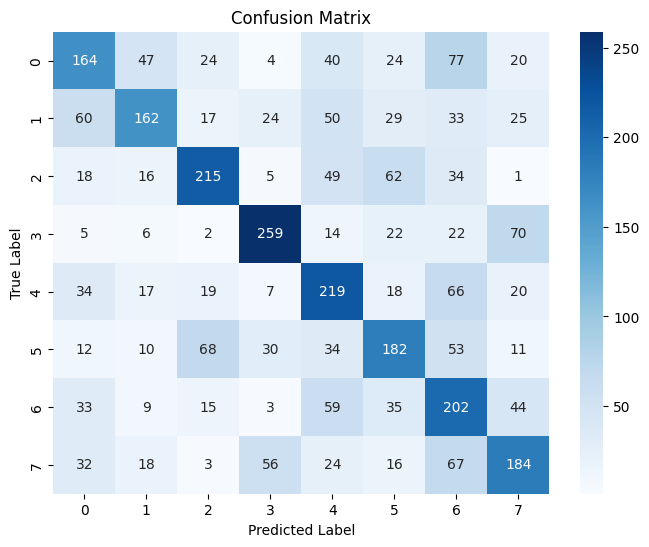

In [10]:
dataset_name, data_directory = 'AffectNet', '../../Datasets/AffectNet_Structured_Aligned'
# dataset_name, data_directory = 'CK+', '../../Datasets/CK+_Structured'
# dataset_name, data_directory = 'FER', '../../Datasets/FER_Structured'
# dataset_name, data_directory = 'JAFFE', '../../Datasets/JAFFE_Structured'
# dataset_name, data_directory = 'RAF-DB', '../../Datasets/RAF-DB_Structured'

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

lr = 0.001
batch_size = 16
momentum = 0.9
weight_decay = 1e-4
patience = 15
num_epochs = 1 #80
model_path = 'Models/ResEmoteNet_AffectNet_best_model_LR_0.001_BS_16_M_0.9_WD_0.0001_P_15_E_300.pth'

TestResEmoteNet(data_directory, model_path, batch_size=15)

# Testing On Single Images

2
Max emotion:  Sad


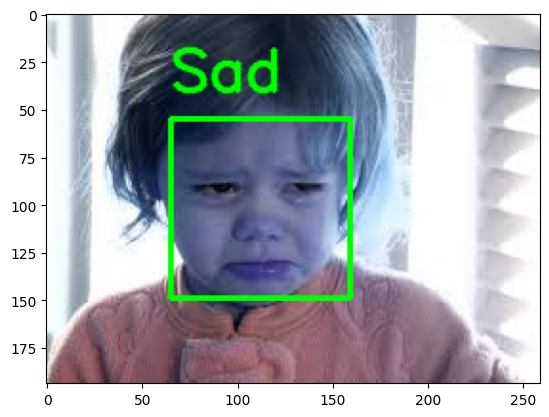

In [63]:
import cv2
import cv2.data
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Emotions labels
# emotions = ['happy', 'surprise', 'sad', 'anger', 'disgust', 'fear']
# emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

emotions = ['Happy', 'Surprise', 'Sad', 'Angry', 'Disgust', 'Fear', 'Neutral']

model = ResEmoteNet().to(device)
# model.load_state_dict(torch.load('ResEmoteNet_JAFFE_best_model_0.001_16_0.95_0.0001.pth', weights_only=True))

# model.load_state_dict(torch.load('Datasets\\FER_ResEmoteNet\\best_model_0.001_16_0.9_0.0001.pth', weights_only=True))

checkpoint = torch.load('paper_fer2013_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)

# Settings for text
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (0, 255, 0)
thickness = 2
line_type = cv2.LINE_AA

max_emotion = ''

def detect_emotion(image):
    img_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = F.softmax(outputs, dim=1)
    scores = probabilities.cpu().numpy().flatten()
    rounded_scores = [round(score, 2) for score in scores]
    return rounded_scores

def get_max_emotion(x, y, w, h, image):
    crop_img = image[y : y + h, x : x + w]
    pil_crop_img = Image.fromarray(crop_img)
    rounded_scores = detect_emotion(pil_crop_img)    
    max_index = np.argmax(rounded_scores)
    max_emotion = emotions[max_index]
    print(max_index)
    return max_emotion

def print_max_emotion(x, y, image, max_emotion):
    org = (x, y - 15)
    cv2.putText(image, max_emotion, org, font, font_scale, font_color, thickness, line_type)
    
def print_all_emotion(x, y, w, h, image):
    crop_img = image[y : y + h, x : x + w]
    pil_crop_img = Image.fromarray(crop_img)
    rounded_scores = detect_emotion(pil_crop_img)
    org = (x + w + 10, y - 20)
    for index, value in enumerate(emotions):
        emotion_str = (f'{value}: {rounded_scores[index]:.2f}')
        y = org[1] + 40
        org = (org[0], y)
        cv2.putText(image, emotion_str, org, font, font_scale, font_color, thickness, line_type)
    
def detect_bounding_box(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray_image, 1.1, 25, minSize=(40, 40))

    if len(faces) < 1:
        # Get image dimensions
        height, width = gray_image.shape[:2]

        # Set coordinates to cover entire image
        x = y = 0
        w = width
        h = height

        # Draw bounding box on face
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Use these coordinates to analyze the full image
        max_emotion = get_max_emotion(x, y, w, h, image)
        print("Max emotion: ", max_emotion)
        # print_max_emotion(x, y, image, max_emotion)
    else:
        for (x, y, w, h) in faces:
            # Draw bounding box on face
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            max_emotion = get_max_emotion(x, y, w, h, image)
            print("Max emotion: ", max_emotion)
            print_max_emotion(x, y, image, max_emotion)
            # print_all_emotion(x, y, w, h, image)
        
        return faces

# Load the image file
# image = cv2.imread('Datasets\\Fer_ResEmoteNet\\test\\test_28721_sad.jpg')
image = cv2.imread('TestImages\\cry.jpeg')
# Process the image
faces = detect_bounding_box(image)

# Display the processed image
plt.imshow(image)